# Linear Gaussian State Space Model
Assume state space model of the form:

$\textbf{Z}_i = \text{transition matrix}@\textbf{Z}_{i-1} + \mathbf{\epsilon}_i$, where $\mathbf{\epsilon}_i \sim \mathcal{N}(\textbf{0}, \text{transition covariance})$
- $\textbf{Z}_i \in \mathbb{R}^{z_{size}}$
- $\text{transition matrix} \in \mathbb{R}^{z_{size}\times z_{size}}$
- $\mathbf{\epsilon}_i \in \mathbb{R}^{z_{size}}$
- $\text{transition covariance} \in \mathbb{R}^{z_{size}\times z_{size}}$

$\textbf{X}_i = \text{observation matrix}@\textbf{Z}_{i} + \mathbf{\beta}_i$, where $\mathbf{\beta}_i \sim \mathcal{N}(\textbf{0}, \text{observation covariance})$
- $\textbf{X}_i \in \mathbb{R}^{x_{size}}$
- $\text{observation matrix} \in \mathbb{R}^{x_{size}\times z_{size}}$
- $\mathbf{\beta}_i \in \mathbb{R}^{x_{size}}$
- $\text{observation covariance} \in \mathbb{R}^{x_{size}\times x_{size}}$

In [6]:
from typing import Optional, Tuple, List

import torch as t
import torch
from torch.distributions import MultivariateNormal, Distribution

"""
Adapted from: https://github.com/rasmusbergpalm/pytorch-lgssm
"""

class LinearGaussianStateSpaceModel:

    def __init__(
            self,
            prior_mean: t.Tensor,
            prior_covariance: t.Tensor,
            transition_matrix: t.Tensor,
            transition_covariance: t.Tensor,
            observation_matrix: t.Tensor,
            observation_covariance: t.Tensor
    ):
        """
        A Linear Gaussian State Space Model implementing the following generative process

        p(z_0) = N(z_0 | prior_mean, prior_covariance)
        p(z_t|z_{t-1}}) = N(z_t |  z_{t-1} @ transition_matrix, transition_covariance)
        p(x_t|z_t) = N(x_t | z_t @ observation_matrix, observation_covariance)

        :param prior_mean: (z_size, )
        :param prior_covariance: (z_size, z_size)

        :param transition_matrix: (z_size, z_size)
        :param transition_covariance: (z_size, z_size)

        :param observation_matrix: (z_size, x_size)
        :param observation_covariance: (x_size, x_size)
        """
        super().__init__()
        self.prior_mean = prior_mean
        self.prior_covariance = prior_covariance
        self.transition_matrix = transition_matrix
        self.transition_covariance = transition_covariance
        self.observation_matrix = observation_matrix
        self.observation_covariance = observation_covariance

        (z_size,) = prior_mean.shape
        (_, x_size) = observation_matrix.shape
        assert prior_covariance.shape == (z_size, z_size)
        assert transition_matrix.shape == (z_size, z_size)
        assert transition_covariance.shape == (z_size, z_size)
        assert observation_matrix.shape == (z_size, x_size)
        assert observation_covariance.shape == (x_size, x_size)

    def _predict(self, z_mean: t.Tensor, z_covariance: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
        x_mean = z_mean @ self.observation_matrix  # (bs, x_size)
        x_covariance = self.observation_covariance + self.observation_matrix.t() @ z_covariance @ self.observation_matrix  # (bs, x_size, x_size)
        return x_mean, x_covariance

    def _observation_fn(self, z: t.Tensor) -> Distribution:
        return MultivariateNormal(z @ self.observation_matrix, self.observation_covariance)

    def _transition_fn(self, z: t.Tensor) -> Distribution:
        return MultivariateNormal(z @ self.transition_matrix, self.transition_covariance)

    def sample(self, n_steps) -> Tuple[t.Tensor, t.Tensor]:
        """
        Sample a sequence of (x, z) from the model

        :param n_steps: how long the sequence should be
        :return: (x_{1:T}, z_{1:T})
        """
        z_seq = [MultivariateNormal(self.prior_mean, self.prior_covariance).sample()]
        x_seq = []
        for _ in range(n_steps):
            x_seq.append(self._observation_fn(z_seq[-1]).sample())
            z_seq.append(self._transition_fn(z_seq[-1]).sample())

        return t.stack(x_seq), t.stack(z_seq[:-1])  # (seq, x), (seq, z)

    def log_prob(self, x_seq: List[Optional[t.Tensor]]):
        """
        Compute the log probability of the input sequence, x_{1:T}.

        Can handle missing input. Use None to signify missing input, e.g. [x_1, x_2, None, x_3]

        :param x_seq: (seq, (batch_size, x_size))
        :return: log p(x_{1:T}}), [log p(x_t|x_{1:t-1}), p(x_t|x_{1:t-1}), p(x_t|x_{1:t}), p(z_t|x_{1:t-1}), p(z_t|x_{1:t})] for each x_t in x_seq

        """
        (z_size, x_size) = self.observation_matrix.shape
        (bs, _) = x_seq[0].shape

        z_prior_mean = self.prior_mean.unsqueeze(0).expand((bs, z_size))  # (bs, z_size)
        z_prior_covariance = self.prior_covariance.unsqueeze(0).expand((bs, z_size, z_size))  # (bs, z_size, z_size)

        steps = []
        for x in x_seq:
            observe_data = x is not None
            x_prior_mean, x_prior_covariance = self._predict(z_prior_mean, z_prior_covariance)  # (bs, x_size), (bs, x_size, x_size)
            if observe_data:
                # (bs, z_size, z_size) @ (z_size, x_size) @ (bs, x_size, x_size)
                K = z_prior_covariance @ self.observation_matrix @ t.inverse(x_prior_covariance)  # (bs, z_size, x_size)
                # ((1, z_size, z_size) - (bs, z_size, x_size) @ (x_size, z_size)) @ (bs, z_size, z_size)
                z_posterior_covariance = (t.eye(z_size, device=x.device).unsqueeze(0) - K @ self.observation_matrix.t()) @ z_prior_covariance  # (bs, z_size, z_size)
                # (bs, z_size) + (bs, z_size, x_size) @ (bs, x_size, 1)
                z_posterior_mean = z_prior_mean + (K @ (x - x_prior_mean).unsqueeze(2)).squeeze()  # (bs, z_size)
                logpx = MultivariateNormal(x_prior_mean, x_prior_covariance).log_prob(x)  # (bs, )
            else:
                logpx = None
                z_posterior_mean = z_prior_mean
                z_posterior_covariance = z_prior_covariance

            x_posterior_mean, x_posterior_covariance = self._predict(z_posterior_mean, z_posterior_covariance)  # (bs, x_size), (bs, x_size, x_size)

            assert not t.any(t.isnan(x_prior_covariance))
            assert not t.any(t.isnan(x_posterior_covariance))
            assert not t.any(t.isnan(z_prior_covariance))
            assert not t.any(t.isnan(z_posterior_covariance))

            steps.append((logpx,
                          MultivariateNormal(x_prior_mean, x_prior_covariance),
                          MultivariateNormal(x_posterior_mean, x_posterior_covariance),
                          MultivariateNormal(z_prior_mean, z_prior_covariance),
                          MultivariateNormal(z_posterior_mean, z_posterior_covariance)
                          ))

            # (z_size, z_size) + (z_size, z_size) @ (bs, z_size, z_size) @ (z_size, z_size)
            z_prior_covariance = self.transition_covariance + self.transition_matrix.t() @ z_posterior_covariance @ self.transition_matrix  # (bs, z_size, z_size)
            # (bs, z_size) @ (z_size, z_size)
            z_prior_mean = z_posterior_mean @ self.transition_matrix

        logpx = t.stack([s[0] for s in steps if s[0] is not None])
        logpx = logpx.sum(dim=0)
        return logpx, steps

In [27]:
a = 0.99
b = 0.01
c = 0.9
d = 0.1
z_size = 1
x_size = 1

prior_mean = torch.zeros(size = (z_size, ))
prior_covariance = torch.ones(size = (z_size, z_size))
transition_matrix = a*torch.ones(size = (z_size, z_size))
transition_covariance = b*torch.ones(size = (z_size, z_size))
observation_matrix = c*torch.ones(size = (x_size, z_size))
observation_covariance = d*torch.ones(size = (x_size, x_size))


model = LinearGaussianStateSpaceModel(prior_mean, prior_covariance, transition_matrix, transition_covariance, observation_matrix, observation_covariance)
x, z = model.sample(1000) #(8, x_dim), (8, z_dim)

x = x[800:]
#logpx, steps = model.log_prob(x.unsqueeze(1)) # Computes log(p(x)) for a batch of sequences x

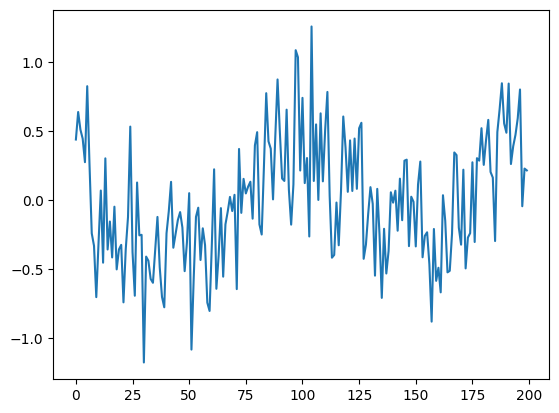

In [28]:
import matplotlib.pyplot as plt
plt.plot(x)